# Heatmapping Notebook

The purpose of this notebook is to create heatmap 'slices' to get a better sense of the shape of the temperature data.

#### Imports and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random

from sklearn.linear_model import Lasso, LinearRegression as LR
from sklearn.linear_model import Ridge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import StandardScaler as SS

from sklearn.model_selection import train_test_split as tts

from IPython.display import clear_output
from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance


In [2]:

def GetColors(N, cmap_name='rainbow'):
    from matplotlib.cm import get_cmap
    import numpy as np

    cmap = get_cmap(name=cmap_name)
    n = np.linspace(0,1,N)
    return cmap(n)

def PlotGroups(points, groups, colors):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,6))

    for i, yi in enumerate(np.unique(groups)):
        idx = (groups == yi)
        plt.scatter(points[idx, 0], points[idx, 1],
                    alpha=0.5, ec='k', color=colors[i], label = yi)
    plt.axis('equal')
    plt.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    #plt.show()
    return

def CompareClasses(actual, predicted, names=None):
    classes = pd.DataFrame(columns=['Predicted','Actual'])
    classes['Predicted'] = predicted
    classes['Actual'] = actual

    conf_mat = pd.crosstab(columns=classes['Predicted'],
                       index = classes['Actual'])
    if names != None:
        conf_mat.columns = names
        conf_mat.index = names

    conf_mat.columns.name = 'Predicted'
    conf_mat.index.name = 'Actual'

    accuracy = sum(predicted==actual)/len(actual)

    return conf_mat, accuracy

def DoKFold(model, X, y, k, scaler=None):
    from sklearn.model_selection import KFold
    import pandas as pd

    kf = KFold(n_splits=k, shuffle=True)

    if type(X) == pd.core.frame.DataFrame:
        X = X.values

    training_scores=[]
    testing_scores=[]

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain,:]
        Xtest = X[idxTest,:]
        ytrain = y[idxTrain]
        ytest = y[idxTest]

        if scaler != None:
            # For standardization:
            # Fit/transform on training data
            Xtrain = scaler.fit_transform(Xtrain)
            #
            # Only transform (i.e, don't refit) on test data
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        training_scores.append(model.score(Xtrain,ytrain))
        testing_scores.append(model.score(Xtest,ytest))

    return training_scores, testing_scores

def plot_train_test(train, test, width, x_lab = None, y_lab = 'Mean Accuracy'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))
    plt.plot(width, train, '-kx')
    plt.plot(width, test, '-rx')
    plt.legend()
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()


### Model simulation code


In [3]:
from math import sqrt
from array import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Colab Notebooks
%run run_model.ipynb
run_model(x_input,t_final)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks


342.2243670511788

Making the grid

In [5]:
import itertools

def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [6]:
def ten_percent_bounds(number):
  lowerbound = number - 0.1*number
  upperbound = number + 0.1*number
  return lowerbound,upperbound

## Get_heatmap (regular)

In [7]:
def get_heatmap(var1,var2):
  """
  This function takes two variables in the run_model equation and creates a heatmap grid from -10% to +10% of the baseline value.

  Example:
  var1 = h_tile
  var2 = ?

  """
  n = 25 # n x n grid

  var1 = str(var1)
  print('var1 = ' + var1)

  var2 = str(var2)
  print('var2 = ' + var2)

  # -----
  # Setting the mean value of var1 and var2
  # -----

  base_var1 = 0
  base_var2 = 0

  if var1 == 't_final':
    base_var1 = 60
  elif var1 == 'h_tile':
    base_var1 = 0.0254
  elif var1 == 'h_Ti':
    base_var1 = 0.00015
  elif var1 == 'rho_tile':
    base_var1 = 144
  elif var1 == 'rho_Ti':
    base_var1 = 4540
  elif var1 == 'cp_tile':
    base_var1 = 628
  elif var1 == 'cp_Ti':
    base_var1 = 460
  elif var1 == 'k_tile':
    base_var1 = 0.126
  elif var1 == 'k_Ti':
    base_var1 = 7.1
  elif var1 == 'emissivity':
    base_var1 = 0.8
  elif var1 == 'M_inf':
    base_var1 = 0.126
  elif var1 == 'p_inf':
    base_var1 = 2736.0
  elif var1 == 'T_inf':
    base_var1 = 284.0
  elif var1 == 'fudge_factor':
    base_var1 = 1.0
  else:
    print("Error: var1 isn't an input")

  print('base_var1 = ' + str(base_var1))

  if var1 == var2:
    print("Error: var1 = var2")
  elif var2 == 't_final':
    base_var2 = 60
  elif var2 == 'h_tile':
    base_var2 = 0.0254
  elif var2 == 'h_Ti':
    base_var2 = 0.00015
  elif var2 == 'rho_tile':
    base_var2 = 144
  elif var2 == 'rho_Ti':
    base_var2 = 4540
  elif var2 == 'cp_tile':
    base_var2 = 628
  elif var2 == 'cp_Ti':
    base_var2 = 460
  elif var2 == 'k_tile':
    base_var2 = 0.126
  elif var2 == 'k_Ti':
    base_var2 = 7.1
  elif var2 == 'emissivity':
    base_var2 = 0.8
  elif var2 == 'M_inf':
    base_var2 = 0.126
  elif var2 == 'p_inf':
    base_var2 = 2736.0
  elif var2 == 'T_inf':
    base_var2 = 284.0
  elif var2 == 'fudge_factor':
    base_var2 = 1.0
  else:
    print("Error: var2 isn't an input")

  print('base_var2 = ' + str(base_var2))

  # -----
  # Creating the grid bounds
  # -----

  lowerbound_1, upperbound_1 = ten_percent_bounds(base_var1)

  print('lowerbound_1 = ' + str(lowerbound_1) + ' | upperbound_1 = ' + str(upperbound_1))

  lowerbound_2, upperbound_2 = ten_percent_bounds(base_var2)

  print('lowerbound_2 = ' + str(lowerbound_2) + ' | upperbound_2 = ' + str(upperbound_2))

  # -----
  # Creating the gridspace
  # -----

  var1_seq = np.linspace(lowerbound_1,upperbound_1,n)

  var2_seq = np.linspace(lowerbound_2,upperbound_2,n)

  plot_df = expand_grid({var1: var1_seq, var2: var2_seq}) # need to make it a new name

  print(plot_df)

  # -----
  # Removing X1 and X2 Columns
  # -----

  var_list = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti','emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

  #print("# of constant variables = "+str(len(var_list)))

  if var1 in var_list:
    var_list.remove(var1)
    #print("# of constant variables = "+str(len(var_list)))

  if var2 in var_list:
    var_list.remove(var2)
    #print("# of constant variables = "+str(len(var_list)))

  # -----
  # Adding Constant Columns
  # -----

  for var in var_list: # remaining variables

    #plot_df[var] = 0 # create a blank column with its title

    if var == 't_final':
      plot_df[var] = 60
    elif var == 'h_tile':
      plot_df[var] = 0.0254
    elif var == 'h_Ti':
      plot_df[var] = 0.00015
    elif var == 'rho_tile':
      plot_df[var] = 144
    elif var == 'rho_Ti':
      plot_df[var] = 4540
    elif var == 'cp_tile':
      plot_df[var] = 628
    elif var == 'cp_Ti':
      plot_df[var] = 460
    elif var == 'k_tile':
      plot_df[var] = 0.126
    elif var == 'k_Ti':
      plot_df[var] = 7.1
    elif var == 'emissivity':
      plot_df[var] = 0.8
    elif var == 'M_inf':
      plot_df[var] = 5
    elif var == 'p_inf':
      plot_df[var] = 2736.0
    elif var == 'T_inf':
      plot_df[var] = 284.0
    elif var == 'fudge_factor':
      plot_df[var] = 1.0

  # -----
  # Reordering Columns
  # -----

  cols = plot_df.columns.tolist()

  cols = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti','emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

  plot_df = plot_df[cols]

  # -----
  # Simulation
  # -----

  simulation_values = []

  for i in range(len(plot_df)): # 15 MIN FUNCTION

    values = plot_df.loc[i]

    simulation_value = run_model(values[1:],values[0])

    simulation_values.append(simulation_value) # make sure t_final is [0]

    print("row "+str(i)+": T_Ti = "+str(simulation_value))


  plot_df['T_Ti'] = simulation_values

  print(plot_df.head())

  # -----
  # Graphing
  # -----

  import matplotlib.pyplot as plt

  x1_grid = plot_df[var1].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  x2_grid = plot_df[var2].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  f_grid = plot_df['T_Ti'].to_numpy().reshape((len(var1_seq),len(var2_seq)))

  plt.pcolormesh(x1_grid,x2_grid,f_grid)

  plt.xlabel(var1)
  plt.ylabel(var2)

  plt.title('Actual Heatmap')

  plt.colorbar()
  plt.clim(300,400)

  plt.show()

  return plot_df, var1, var2, var1_seq, var2_seq # save the output!

## Executing get_heatmap()

var1 = h_tile
var2 = cp_tile
base_var1 = 0.0254
base_var2 = 628
lowerbound_1 = 0.02286 | upperbound_1 = 0.02794
lowerbound_2 = 565.2 | upperbound_2 = 690.8
      h_tile     cp_tile
0    0.02286  565.200000
1    0.02286  570.433333
2    0.02286  575.666667
3    0.02286  580.900000
4    0.02286  586.133333
..       ...         ...
620  0.02794  669.866667
621  0.02794  675.100000
622  0.02794  680.333333
623  0.02794  685.566667
624  0.02794  690.800000

[625 rows x 2 columns]
row 0: T_Ti = 381.2842593694639
row 1: T_Ti = 380.0139739138584
row 2: T_Ti = 378.76452262749524
row 3: T_Ti = 377.5355412893175
row 4: T_Ti = 376.326672577395
row 5: T_Ti = 375.1375658527653
row 6: T_Ti = 373.9678771351257
row 7: T_Ti = 372.8172688380299
row 8: T_Ti = 371.685409762681
row 9: T_Ti = 370.57197486456573
row 10: T_Ti = 369.4766452322468
row 11: T_Ti = 368.39910789147615
row 12: T_Ti = 367.33905569720207
row 13: T_Ti = 366.29618721680976
row 14: T_Ti = 365.270206655113
row 15: T_Ti = 364.26082368436494

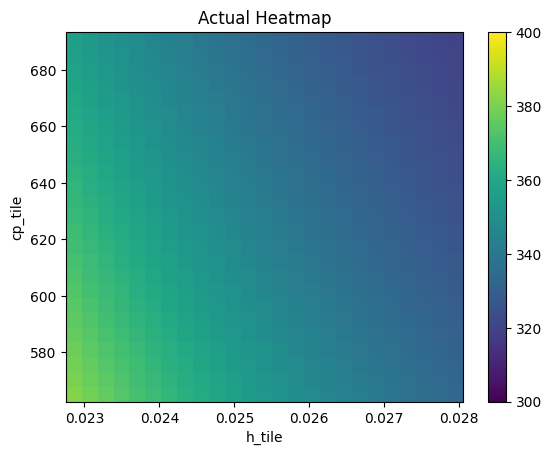

In [8]:
plot_df, var1, var2, var1_seq, var2_seq = get_heatmap('h_tile','cp_tile')

# next, cp_Ti, k_Ti (useless)

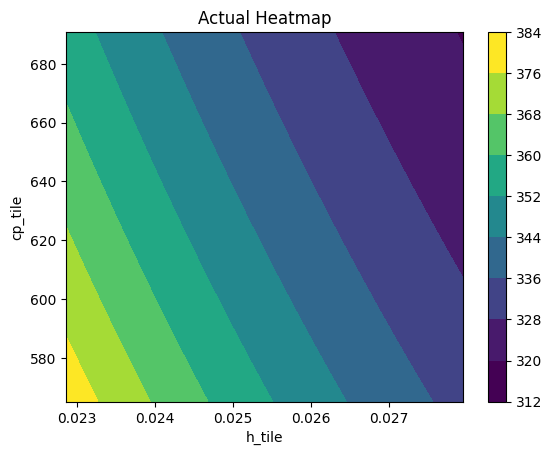

In [9]:
  # -----
  # Graphing
  # -----

import matplotlib.pyplot as plt

x1_grid = plot_df[var1].to_numpy().reshape((len(var1_seq),len(var2_seq)))
x2_grid = plot_df[var2].to_numpy().reshape((len(var1_seq),len(var2_seq)))
f_grid = plot_df['T_Ti'].to_numpy().reshape((len(var1_seq),len(var2_seq)))

#plt.pcolormesh(x1_grid,x2_grid,f_grid)
plt.contourf(x1_grid,x2_grid,f_grid)

plt.xlabel(var1)
plt.ylabel(var2)

plt.colorbar()
plt.clim(320,380)

plt.title('Actual Heatmap')

plt.show()

In [10]:
expand_grid({'x': (0,1,2), 'y': (3,4,5)})

,x,y
0,0,3
1,0,4
2,0,5
3,1,3
4,1,4
5,1,5
6,2,3
7,2,4
8,2,5


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

plot_df_scaled = scaler.fit_transform(plot_df)

plot_df_scaled = pd.DataFrame(plot_df_scaled)

list(plot_df_scaled.loc[0])

[0.0,
 -1.6641005886756872,
 0.0,
 0.0,
 0.0,
 -1.6641005886756877,
 0.0,
 2.7755575615628914e-17,
 0.0,
 1.1102230246251565e-16,
 0.0,
 0.0,
 0.0,
 0.0,
 2.677744659618482]

# MAKING A PREDICTED HEATMAP



## *Models and import statements*

In [12]:
# Set up
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures as PF
from IPython.display import clear_output
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

constant = 1
kernel = constant * RBF(length_scale= 1.0 , length_scale_bounds=(1e-3, 1e3)) #+ WhiteKernel(noise_level=0.5)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)

rfr = RFR(n_estimators = 100)

lasso = Lasso(alpha = 0.25)

linear = LinearRegression()


## ML Predicted Heatmap

In [13]:
def get_heatmap_pred(var1,var2,model,s):
  """
  This function takes two variables in the run_model equation and creates a heatmap grid from -10% to +10% of the baseline value.

  Example:
  var1 = h_tile
  var2 = cp_tile
  model = gpr

  """
  n = 25 # n x n grid

  var1 = str(var1)
  print('var1 = ' + var1)

  var2 = str(var2)
  print('var2 = ' + var2)

  print('model = ' + str(model))

  # -----
  # Setting the mean value of var1 and var2
  # -----

  base_var1 = 0
  base_var2 = 0

  if var1 == 't_final':
    base_var1 = 60
  elif var1 == 'h_tile':
    base_var1 = 0.0254
  elif var1 == 'h_Ti':
    base_var1 = 0.00015
  elif var1 == 'rho_tile':
    base_var1 = 144
  elif var1 == 'rho_Ti':
    base_var1 = 4540
  elif var1 == 'cp_tile':
    base_var1 = 628
  elif var1 == 'cp_Ti':
    base_var1 = 460
  elif var1 == 'k_tile':
    base_var1 = 0.126
  elif var1 == 'k_Ti':
    base_var1 = 7.1
  elif var1 == 'emissivity':
    base_var1 = 0.8
  elif var1 == 'M_inf':
    base_var1 = 0.126
  elif var1 == 'p_inf':
    base_var1 = 2736.0
  elif var1 == 'T_inf':
    base_var1 = 284.0
  elif var1 == 'fudge_factor':
    base_var1 = 1.0
  else:
    print("Error: var1 isn't an input")

  print('base_var1 = ' + str(base_var1))

  if var1 == var2:
    print("Error: var1 = var2")
  elif var2 == 't_final':
    base_var2 = 60
  elif var2 == 'h_tile':
    base_var2 = 0.0254
  elif var2 == 'h_Ti':
    base_var2 = 0.00015
  elif var2 == 'rho_tile':
    base_var2 = 144
  elif var2 == 'rho_Ti':
    base_var2 = 4540
  elif var2 == 'cp_tile':
    base_var2 = 628
  elif var2 == 'cp_Ti':
    base_var2 = 460
  elif var2 == 'k_tile':
    base_var2 = 0.126
  elif var2 == 'k_Ti':
    base_var2 = 7.1
  elif var2 == 'emissivity':
    base_var2 = 0.8
  elif var2 == 'M_inf':
    base_var2 = 0.126
  elif var2 == 'p_inf':
    base_var2 = 2736.0
  elif var2 == 'T_inf':
    base_var2 = 284.0
  elif var2 == 'fudge_factor':
    base_var2 = 1.0
  else:
    print("Error: var2 isn't an input")

  print('base_var2 = ' + str(base_var2))

  # -----
  # Creating the grid bounds
  # -----

  lowerbound_1, upperbound_1 = ten_percent_bounds(base_var1)

  print('lowerbound_1 = ' + str(lowerbound_1) + ' | upperbound_1 = ' + str(upperbound_1))

  lowerbound_2, upperbound_2 = ten_percent_bounds(base_var2)

  print('lowerbound_2 = ' + str(lowerbound_2) + ' | upperbound_2 = ' + str(upperbound_2))

  # -----
  # Creating the gridspace
  # -----

  var1_seq = np.linspace(lowerbound_1,upperbound_1,n)

  var2_seq = np.linspace(lowerbound_2,upperbound_2,n)

  plot_df = expand_grid({var1: var1_seq, var2: var2_seq}) # need to make it a new name

  print(plot_df)

  # -----
  # Removing X1 and X2 Columns
  # -----

  var_list = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti','emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

  #print("# of constant variables = "+str(len(var_list)))

  if var1 in var_list:
    var_list.remove(var1)
    #print("# of constant variables = "+str(len(var_list)))

  if var2 in var_list:
    var_list.remove(var2)
    #print("# of constant variables = "+str(len(var_list)))

  # -----
  # Adding Constant Columns
  # -----

  for var in var_list: # remaining variables

    #plot_df[var] = 0 # create a blank column with its title

    if var == 't_final':
      plot_df[var] = 60
    elif var == 'h_tile':
      plot_df[var] = 0.0254
    elif var == 'h_Ti':
      plot_df[var] = 0.00015
    elif var == 'rho_tile':
      plot_df[var] = 144
    elif var == 'rho_Ti':
      plot_df[var] = 4540
    elif var == 'cp_tile':
      plot_df[var] = 628
    elif var == 'cp_Ti':
      plot_df[var] = 460
    elif var == 'k_tile':
      plot_df[var] = 0.126
    elif var == 'k_Ti':
      plot_df[var] = 7.1
    elif var == 'emissivity':
      plot_df[var] = 0.8
    elif var == 'M_inf':
      plot_df[var] = 5
    elif var == 'p_inf':
      plot_df[var] = 2736.0
    elif var == 'T_inf':
      plot_df[var] = 284.0
    elif var == 'fudge_factor':
      plot_df[var] = 1.0

  # -----
  # Reordering Columns
  # -----

  cols = plot_df.columns.tolist()

  cols = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti','emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

  plot_df = plot_df[cols]

  # -----
  # Model Fitting
  # -----

  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()

  plot_df_scaled = scaler.fit_transform(plot_df)
  plot_df_scaled = pd.DataFrame(plot_df_scaled)

  # -----
  # Training ML model
  # -----

  LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
  LHS_data = pd.read_csv(LHS_url, index_col = 0)
  LHS_data = LHS_data.reset_index()

  scaled_LHS = scaler.fit_transform(LHS_data)
  scaled_LHS = pd.DataFrame(scaled_LHS)

  indexes = random.sample(range(0, len(scaled_LHS)), s) # change s

  sample_data = scaled_LHS.loc[indexes]
  sample_y = LHS_data['simulation_values'].loc[indexes]

  X = sample_data.loc[:,0:13]
  y = sample_y

  print("Train test splitting")

  from sklearn.model_selection import train_test_split

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  print("Train test splitted")

  # -----
  # GPR
  # -----

  print("Fitting model")

  model.fit(X_train, y_train)

  print("Model fitted")

  model_MAE = mean_absolute_error(y_test, model.predict(X_test))
  model_MAE = round(model_MAE,2)

  print("Model MAE = "+str(model_MAE)) # is the model good?

  values = plot_df_scaled
  predicted_values = model.predict(values)
  plot_df['Predicted T_Ti'] = predicted_values

  print(plot_df.head())

  # -----
  # Graphing
  # -----

  import matplotlib.pyplot as plt

  x1_grid = plot_df[var1].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  x2_grid = plot_df[var2].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  f_grid = plot_df['Predicted T_Ti'].to_numpy().reshape((len(var1_seq),len(var2_seq)))

  #plt.pcolormesh(x1_grid,x2_grid,f_grid)
  plt.contourf(x1_grid,x2_grid,f_grid)

  plt.xlabel(var1)
  plt.ylabel(var2)

  plt.colorbar()
  plt.clim(320,384)

  plt.title('Predicted Heatmap (s=' +str(s)+', mae='+str(model_MAE)+')')

  plt.show()

  return plot_df, var1, var2, var1_seq, var2_seq # save the output!

## Executing Function

var1 = h_tile
var2 = cp_tile
model = Lasso(alpha=0.25)
base_var1 = 0.0254
base_var2 = 628
lowerbound_1 = 0.02286 | upperbound_1 = 0.02794
lowerbound_2 = 565.2 | upperbound_2 = 690.8
      h_tile     cp_tile
0    0.02286  565.200000
1    0.02286  570.433333
2    0.02286  575.666667
3    0.02286  580.900000
4    0.02286  586.133333
..       ...         ...
620  0.02794  669.866667
621  0.02794  675.100000
622  0.02794  680.333333
623  0.02794  685.566667
624  0.02794  690.800000

[625 rows x 2 columns]
Train test splitting
Train test splitted
Fitting model
Model fitted
Model MAE = 2.84
   t_final   h_tile     h_Ti  rho_tile  rho_Ti     cp_tile  cp_Ti  k_tile  \
0       60  0.02286  0.00015       144    4540  565.200000    460   0.126   
1       60  0.02286  0.00015       144    4540  570.433333    460   0.126   
2       60  0.02286  0.00015       144    4540  575.666667    460   0.126   
3       60  0.02286  0.00015       144    4540  580.900000    460   0.126   
4       60  0.02286  0.0

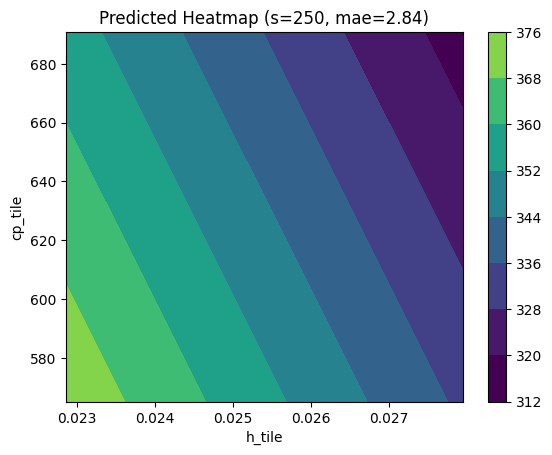

In [14]:
plot_df_pred, var1_pred, var2_pred, var1_seq_pred, var2_seq_pred = get_heatmap_pred('h_tile', 'cp_tile', lasso, 250)